<a href="https://colab.research.google.com/github/qugok/MIPT-Networks-Course-2021-/blob/main/hw6/Assignment_6_Duffusion_and_Epidemics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment — Diffusions and Epidemics on Graphs

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import trange
from zlib import adler32

### Task 1. Diffusions on networks (0 points)

A diffusion process is a propagation model, where node values $\phi$ (say, 'heat') spread out of high concentration zone. Consider the diffusion on grid of the size 20x20. Let there be a 3x3 sub-grid with a heat value 3 and a 7x5 sub-grid with a heat value 1. All other nodes has a value 0. The initial heat values is $\phi_0$.

In [6]:
phi_map = np.zeros((20, 20))
phi_map[1:4, 1:4] = 3
phi_map[10:15, 8:15] = 1
phi0 = phi_map.flatten()

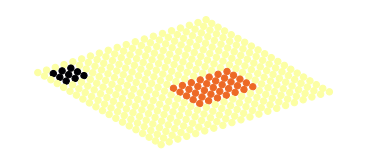

In [7]:
plt.figure(figsize=(7*0.7, 3*0.7))
gridG = nx.grid_graph((20, 20))
nx.draw_kamada_kawai(
    gridG,
    cmap=plt.cm.inferno_r,
    vmin=0, vmax=3,
    width=0,
    node_size=40,
    node_color=phi0)

Create a diffusion simulation based on this diffusion equation

$$\frac{d\phi}{dt} = -CL\phi$$

where $L$ is a graph Laplacian.

Write a function `next_phi` that takes an adjacency matrix `A`, np.array with previous heat values `phi`, constant `C` and time increment `dt`. The function returns a np.array with the next heat values.

In [8]:
def next_phi(A, phi, C, dt):
    ### BEGIN SOLUTION
    D = np.diag(A.sum(axis=1))
    L = D - A
    d_phi = -C * L @ phi * dt
    return phi + d_phi
    ### END SOLUTION

In [9]:
A = nx.to_numpy_array(gridG)
C = 0.1
dt = 2
phi = next_phi(A, phi0, C, dt)
assert phi.shape == (400,)
assert phi.sum() == phi0.sum()
assert phi.std() < phi0.sum()
assert round(phi[20:25].sum(), 4) == 7.2

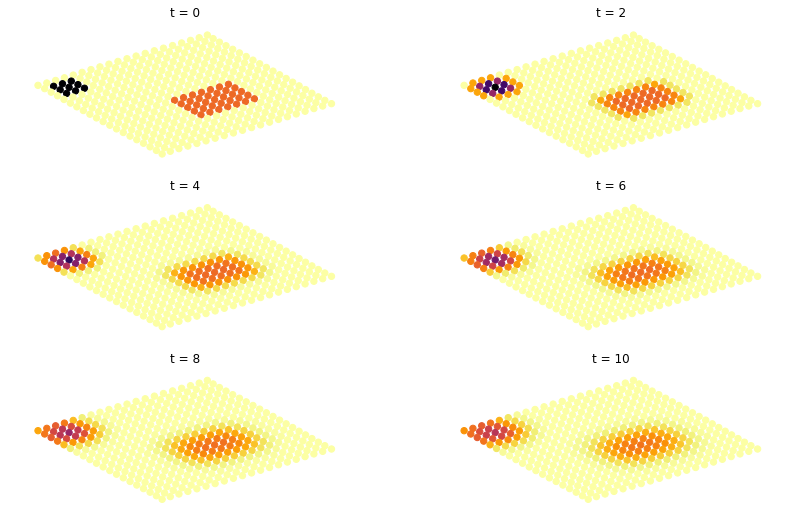

In [10]:
plt.figure(figsize=(7*2, 3*3))

phi = phi0
for i in range(6):
    plt.subplot(3, 2, i+1)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi)
    plt.title('t = {}'.format(i*dt))
    phi = next_phi(A, phi, C, dt)
phi12 = phi

We can run simulation step-by-step as long as we need, but fortunately, there is an analytical solution

$$\phi(t) = \sum_k a_k(t) v_k = \sum_k a_k(0) e^{-C\lambda_k t} v_k$$

where $a_k(t) = \phi(t)^T v_k$ and $v_k$ is k-th smallest eigenvector of a Laplacian.

Write a function `phi_t` that takes an adjacency matrix `A`, np.array with initial heat values `phi0`, constant `C` and time moment `t`. The function returns a np.array with the heat values at time moment `t`. Use `np.linalg.eigh` or `scipy.linalg.eigh` for a symmetric matrix.

In [11]:
def phi_t(A, phi0, C, t):
    ### BEGIN SOLUTION
    D = np.diag(A.sum(axis=1))
    L = D - A
    vals, vecs = np.linalg.eigh(L)
    vals = vals[np.argsort(vals)]
    vecs = vecs[:, np.argsort(vals)]
    return ((phi0 @ vecs) * np.exp(-C * vals * t) * vecs).sum(axis=1)
    ### END SOLUTION

In [12]:
assert phi_t(A, phi0, C, 0).shape == (400,)
assert round(np.linalg.norm(phi0 - phi_t(A, phi0, C, 0)), 4) == 0
assert round(np.linalg.norm(phi12 - phi_t(A, phi0, C, 12)), 4) < 0.4
assert len(np.unique(phi_t(A, phi0, C, 10000).round(4))) == 1
assert phi_t(A, phi0, C, 10000).round(4)[0] == phi0.sum() / len(phi0)

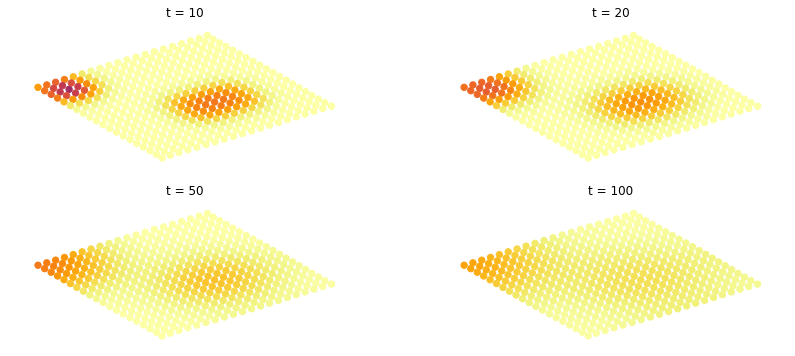

In [13]:
plt.figure(figsize=(7*2, 3*2))
i = 1
for t in [10, 20, 50, 100]:
    plt.subplot(2, 2, i)
    gridG = nx.grid_graph((20, 20))
    nx.draw_kamada_kawai(
        gridG,
        cmap=plt.cm.inferno_r,
        vmin=0, vmax=3,
        width=0,
        node_size=40,
        node_color=phi_t(A, phi0, C, t))
    plt.title('t = {}'.format(t))
    i += 1

### Task 2. SI model (0 points)

Consider a simple model of an epidemic — SI model. S — susceptible, I — infectious. Initialy we only have a few infected persons and all others are susceptible. Then some susceptible people become infected with infection rate $\beta$. The model is defined as follows:

Dynamic form

$$S \underset{\beta SI}{\to} I$$

Equation form

$$\frac{dI}{dt} = \beta \frac{S}{N}I$$

$$S + I = N$$

where $N$ is the total population.

Write a function `si_epidemic` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, time increment `dt`, number of iterations `k` and returns a returns np.array with solution of the form `[[S0, I0], [S1, I1], ...]` so that number of rows is k+1.

In [14]:
def si_epidemic(total, I0, beta, dt, k):
    ### BEGIN SOLUTION
    res = [[total - I0, I0]]
    S, I = res[-1]
    for _ in range(k):
        dI = beta * S / total * I * dt
        I += dI
        S = total - I
        res.append([S, I])
    return np.array(res)
    ### END SOLUTION

In [15]:
solution = si_epidemic(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert solution.shape == (130, 2)
assert np.all(solution[0] == [999, 1])
assert np.all(solution[10].round(2) == [995.97, 4.03])
assert np.all(solution[-1].round(2) == [0, 1000])
assert adler32(str(solution[100].round(2)[0]).encode()) == 32047304

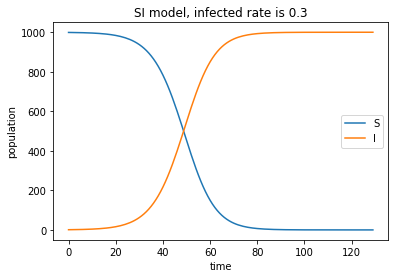

In [16]:
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

Let us look at the plot of epidemic dynamics with the same setup but $\beta = 0.1$.

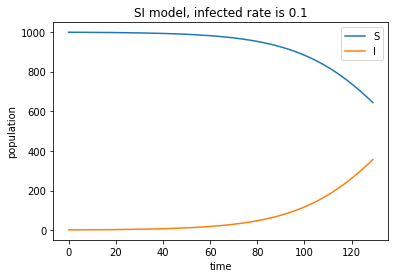

In [17]:
solution = si_epidemic(total=1000, I0=1, beta=0.1, dt=0.5, k=130-1)
plt.plot(solution)
plt.legend(['S', 'I'])
plt.title('SI model, infected rate is 0.1')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 3. Numerical vs analytical solution of SI model (1.5 points)

The SI model has an analytical solution

$$i(t) = \frac{i_0}{i_0 + (1 - i_0)e^{-\beta t}}$$

where $i(t)$ is the share of infected people at time moment $t$. Let us compare the analytical solution and Euler method.

Write a function `si_epidemic_analytically` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, time increment `dt`, number of iterations `k` and returns np.array `[[S0, I0], [S1, I1], ...]` is an analytical solution so that number of rows is `k+1`.

In [18]:
def si_epidemic_analytically(total, I0, beta, dt, k):
    i0 = I0 / total
    def it(t):
       return i0 / (i0 + (1 - i0) * np.math.pow(np.e, -beta*t))
    iths = []
    for a in range (k+1):
        iths.append(it(dt * a))
    return np.array([(total*(1 - i), total * i) for i in iths])
    raise NotImplementedError()

In [19]:
analytical_solution = si_epidemic_analytically(total=1000, I0=1, beta=0.3, dt=0.5, k=130-1)
assert analytical_solution.shape == (130, 2)
assert np.all(analytical_solution[0] == [999, 1])
assert np.all(analytical_solution[10].round(2) == [995.53, 4.47])
assert np.all(analytical_solution[-1].round(2) == [0, 1000])
assert adler32(str(analytical_solution[100].round(2)[0]).encode()) == 31785155

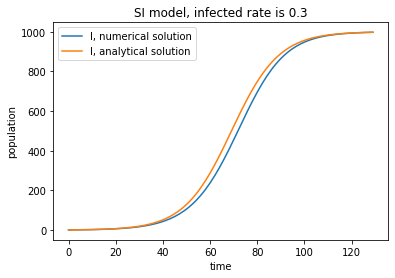

In [20]:
solution = si_epidemic(total=1000, I0=1, beta=0.2, dt=0.5, k=130-1)
analytical_solution = si_epidemic_analytically(total=1000, I0=1, beta=0.2, dt=0.5, k=130-1)
plt.plot(solution[:, 1], label='I, numerical solution')
plt.plot(analytical_solution[:, 1], label='I, analytical solution')
plt.legend()
plt.title('SI model, infected rate is 0.3')
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 4. SIS model (1.5 points)

Next, consider SIS model. S — susceptible, I — infectious. At the next time moment, some susceptible people become infected with infection rate $\beta$ and some infected people become susceptible with recovery rate $\gamma$. The model is defined as follows:

Dynamic form

$$S \underset{\beta S I}{\to} I \underset{\gamma I}{\to} S$$

Equation form

$$\frac{dI}{dt} = \beta \frac{S}{N}I - \gamma I$$

$$S + I = N$$

where $N$ is the total population. 

Write a function `sis_epidemic` that takes the total population `total`, number of infected people `I0`, infected rate `beta`, recovery rate `gamma`, time increment `dt`, number of iterations `k` and returns a solution of the form of a np.array

`[[S0, I0], [S1, I1], ...]`

so that number of rows is `k+1`.

In [21]:
def sis_epidemic(total, I0, beta, gamma, dt, k):
    res = [[total - I0, I0]]
    S, I = res[-1]
    for _ in range(k):
        dI = beta * S / total * I * dt - gamma * I * dt
        I += dI
        S = total - I
        res.append([S, I])
    return np.array(res)

In [22]:
total = 1000
beta, gamma = 0.3, 0.1
solution = sis_epidemic(total=total, I0=100, beta=beta, gamma=gamma, dt=0.2, k=600-1)
assert solution.shape == (600, 2)
assert np.all(solution[0] == [900, 100])
assert np.all(solution[10].round(2) == [861.63, 138.37])
assert solution[-1, 1].round(2) == round((1 - gamma / beta) * total, 2)
assert adler32(str(solution[100].round(2)[0]).encode()) == 72548667

Here is the critical point for a basic reproduction number $R_0 = \beta / \gamma$

* If $R_0 > 1$: Endemic State,  $i(+\infty) \to (1 - \gamma / \beta)$
* If $R_0 < 1$: Disease-free State, $i(+\infty) \to 0$

where $i(t)$ is the share of infected people at the time moment $t$.

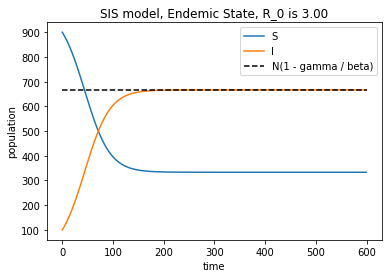

In [23]:
plt.plot(solution)
limit = (1 - gamma / beta) * total
plt.plot([0, 600], [limit, limit], '--', c='black')
plt.legend(['S', 'I', 'N(1 - gamma / beta)'])
plt.title('SIS model, Endemic State, R_0 is {:.2f}'.format(beta / gamma))
plt.xlabel('time')
plt.ylabel('population')
plt.show()

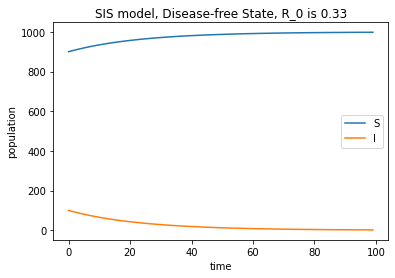

In [24]:
beta, gamma = 0.1, 0.3
solution = sis_epidemic(total=total, I0=100, beta=beta, gamma=gamma, dt=0.2, k=100-1)
plt.plot(solution)
limit = (1 - gamma / beta) * total
plt.legend(['S', 'I'])
plt.title('SIS model, Disease-free State, R_0 is {:.2f}'.format(beta / gamma))
plt.xlabel('time')
plt.ylabel('population')
plt.show()

### Task 5. Probabilistic node-level models. SIS (0 points)

Let us consider epidemic models on networks. SIS model is described by a dynamic form

$$S \to_{\beta SI} I \to_{\gamma I} S$$

To model epidemics on networks, we need to use probabilistic approach. First, let us define a function that gives us a random sample of available nodes by given probability.

Here is a function `select_nodes` that takes a np.array `vec`, where an i-th element is a number of neighbors that can affect to i-th node with probability `proba`. For example, `vec` can represent the number of infected neighbors, say [0, 2, 1] and then the probability is an infected rate $\beta$. That means the first node has no infected neighbors, the second has two infected neighbors, the third has one infected neighbor. Thereby, the second node has a $(1 - (1-\beta)^2)$ probability of getting infected.

In [25]:
def select_nodes(vec, proba):
    sample = np.random.rand(len(vec))
    res = sample < (1 - (1 - proba)**vec)
    return res.astype('int')

Let us infect a few random nodes and simulate a propogation of an epidemic.

Write a function `sis_networks` that takes a graph `G`, np.array with an initial indicator vector `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I`). Any node must be susceptible or infected at any step. Also the function takes rates `beta`, `gamma`, number of steps `k`. The function returns a np.array of shape `(k+1, 2, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column and `I` in the second.

_Hint: to calculate the number of infected neighbors, use `I @ A * S`_

In [26]:
def sis_networks(G, S, I, beta, gamma, k):
    ### BEGIN SOLUTION
    A = nx.to_numpy_array(G)
    epidemic = []
    epidemic.append([S, I])
    for _ in range(k):
        dI = select_nodes(I @ A * S, beta) - select_nodes(I, gamma)
        I = I + dI
        S = 1 - I
        epidemic.append([S, I])
    return np.array(epidemic)
    ### END SOLUTION

In [27]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.2

epidemic = sis_networks(G, S, I, beta, gamma, 100)
assert epidemic.sum() == 5050
assert epidemic.shape == (101, 2, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050
sigma = 6.3853
mean = 16.0198
assert mean - 2*sigma < round(epidemic.sum(axis=2)[:, 0].mean(), 4) < mean + 2*sigma
sigma = 5.953
mean = 34.2178
assert mean - 2*sigma < round(epidemic.sum(axis=2)[:, 1].mean(), 4) < mean + 2*sigma

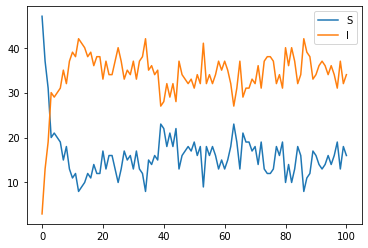

In [28]:
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I']);

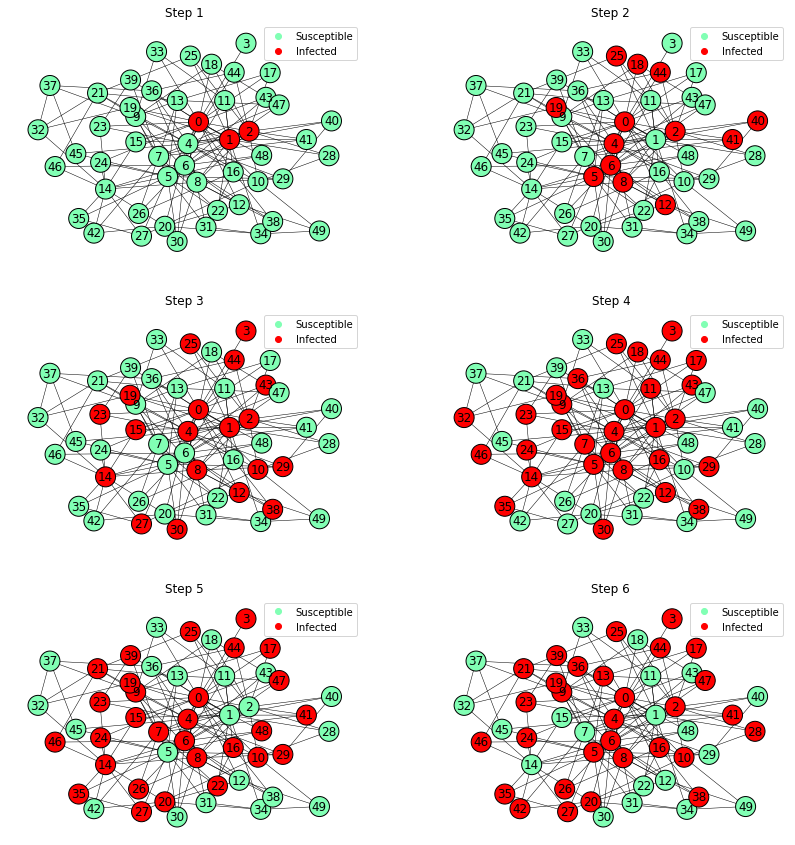

In [29]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=I+1, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

### Task 6. Probabilistic node-level models. SIRS (1.5 points)

Let us implement SIRS node-level model
$$S \to_{\beta SI} I \to_{\gamma I} R \to_{\delta R} S$$

Write a function `sirs_networks` that takes a graph `G`, np.array with initial indicator `S` where `S[i]` is 1 if i-th node is susceptible and 0 otherwise (the same for `I` and `R`). Also the function takes rates `beta`, `gamma`, `delta`, number of steps `k`. The function returns a np.array of shape `(k+1, 3, n)` where `n` is a number of nodes. At i-th step, the matrix `result[i, :, :]` contains indicator `S` in the first column, `I` in the second, `R` in the third.

In [30]:
def sirs_networks(G, S, I, R, beta, gamma, delta, k):
    A = nx.to_numpy_array(G)
    epidemic = []
    epidemic.append([S, I, R])
    for _ in range(k):
        mS = select_nodes(I @ A * S, beta)
        mI = select_nodes(I, gamma)
        mR = select_nodes(R, delta)
        I = I - mI + mS
        S = S - mS + mR
        R = R - mR + mI
        epidemic.append([S, I, R])
    return np.array(epidemic)

In [31]:
G = nx.barabasi_albert_graph(40, 3, seed=0)
I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
R = np.zeros(len(G))

beta = 0.1
gamma = 0.3
delta = 0.1

epidemic = sirs_networks(G, S, I, R, beta, gamma, delta, 200)
assert epidemic.shape == (201, 3, 40)
assert (epidemic.sum(axis=1) == 1).sum() == 8040
assert (epidemic[200].sum(axis=1) == [40, 0, 0]).sum() == 3

for k in range(6):
    for node in G.nodes:
        if epidemic[k, 0, node] > epidemic[k+1, 0, node]:
            assert epidemic[k+1, 1, node] == 1
            neighbors = np.array([n for n in G.neighbors(node)])
            assert epidemic[k, 1][neighbors].sum()
        elif epidemic[k, 1, node] > epidemic[k+1, 1, node]:
            assert epidemic[k+1, 2, node] == 1
        elif epidemic[k, 2, node] > epidemic[k+1, 2, node]:
            assert epidemic[k+1, 0, node] == 1

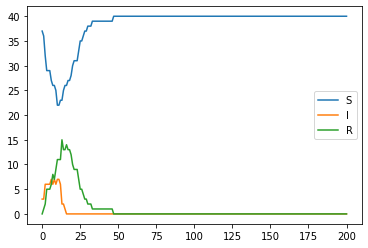

In [32]:
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I', 'R']);

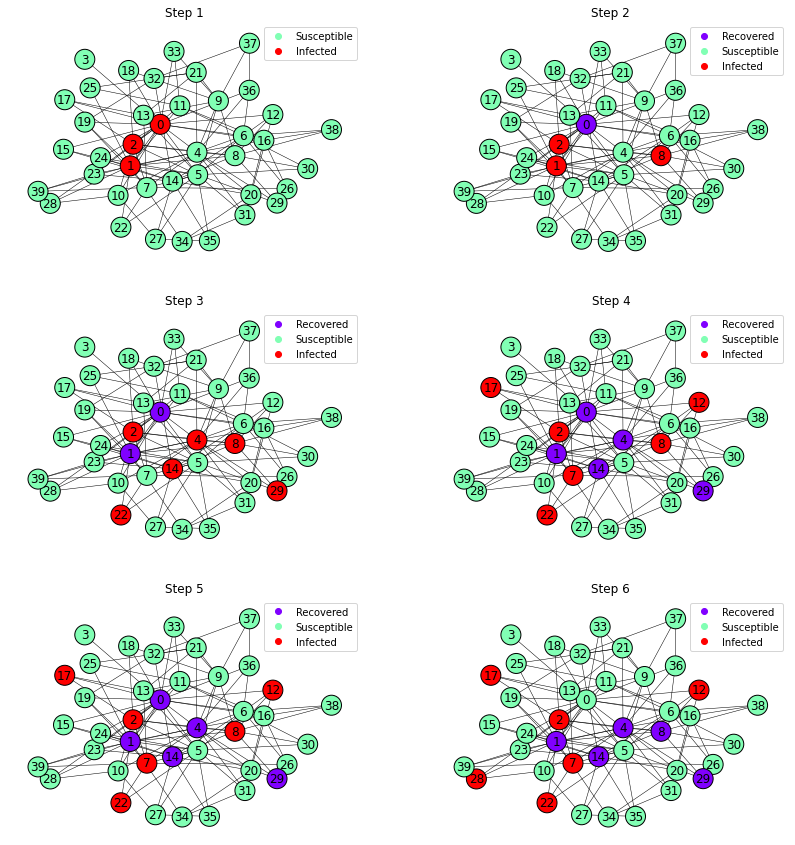

In [33]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I, R in epidemic[:6]:
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=(S + I*2), 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    if len(nodes.legend_elements()[0]) == 2:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Susceptible', 'Infected'])
    else:
        plt.legend(
            nodes.legend_elements()[0], 
            ['Recovered', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

We can also can model "the second waves" using delta parameter

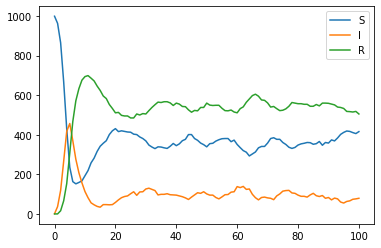

In [34]:
G = nx.barabasi_albert_graph(1000, 3, seed=0)

I = np.zeros(len(G))
I[0] = 1
S = 1 - I
R = np.zeros(len(G))

epidemic = sirs_networks(G, S, I, R, 0.3, 0.4, 0.07, 100)
plt.plot(epidemic.sum(axis=2))
plt.legend(['S', 'I', 'R']);

### Task 7. Random Immunization for SIS model  (1.5 point)

Immunization strategies specify how vaccines, treatments or drugs are distributed in the population. Ideally, should a treatment or vaccine exist, it should be given to every infected individual or those at risk of contracting the pathogen.
However, it is costly to vaccinate all risky people. Given these constraints, immunization strategies aim to minimize the threat of a pandemic by most effectively distributing the available vaccines or treatments.

The general idea of immunization is to reduce infected rate $\beta$ to critical point. So the virus naturally dies out.

The immune nodes are invisible for the virus. So `randomly_immunized_sis_model` should work in following pipeline:

1. Select share `g` of nodes randomly (round number of selected nodes with int function)
2. Remove all edges adjacent to selected nodes
3. Run `sis_networks` model
4. Add removed edges

The `randomly_immunized_sis_model` method should return tuple with np.array of immunized nodes and output of `sis_networks` model for immunized graph.

_Hint: use `np.random.choice` to select random subsample_

In [36]:
def randomly_immunized_sis_model(g, G, S, I, beta, gamma, k):
    immun = np.random.choice(G.nodes(), int(g*G.number_of_nodes()))
    tempG = G.copy()
    for i in immun:
        tempG.remove_edges_from([(i, k) for k in G.nodes()])
    return (immun, sis_networks(tempG, S, I, beta, gamma, k))

In [37]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.1
g = 0.5

immune, epidemic = randomly_immunized_sis_model(g, G, S, I, beta, gamma, 100)
assert epidemic.sum() == 5050
assert epidemic.shape == (101, 2, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050

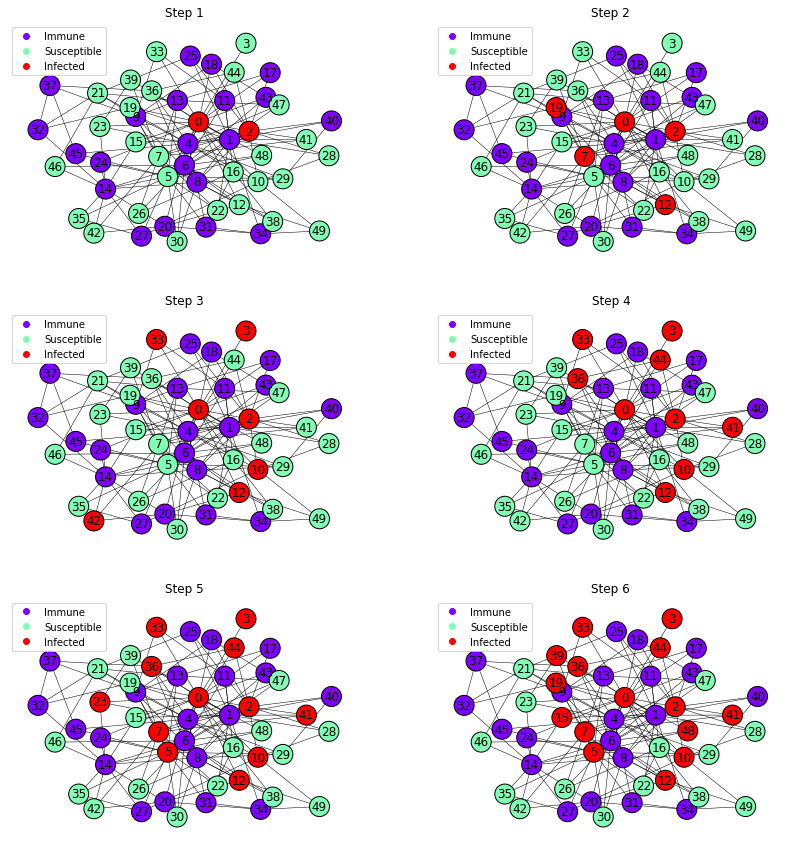

In [38]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    colors = I + 1
    colors[immune] = -1
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Immune', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

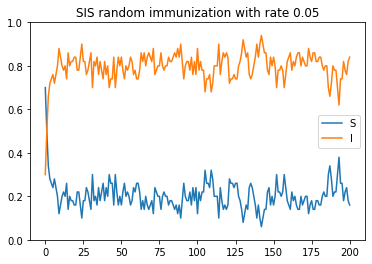

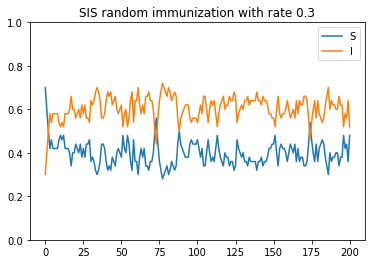

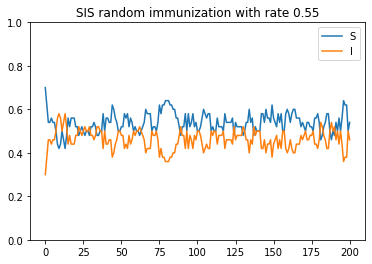

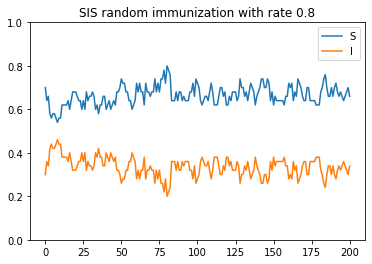

In [39]:
for i in range(1, 20, 5):
    immune, epidemic = randomly_immunized_sis_model(i / 20, G, S, I, beta, gamma, 200)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS random immunization with rate {i / 20}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)
    plt.show()

### Task 8. Selective Immunization for SIS (1.5 points)

The random immunization can help, but requires a large part of population to be vaccinized.
So we can propose the better immunization strategy named `Selective Immunization`.

The general idea of Selective Immuzation is to immunize hubs (nodes with the largest degree).

Here you need to define function `selectively_immunized_sis_model`. It works similar to the `randomly_immunized_sis_model`:

1. Select a part `g` of nodes with highest degree
2. Remove all edges adjacent to selected nodes
3. Run `sis_networks` model
4. Add removed edges

In [48]:
def selectively_immunized_sis_model(g, G, S, I, beta, gamma, k):
    immun = [a for a, b in sorted(G.degree(), key=lambda x : x[1], reverse = True)[:int(g*G.number_of_nodes())]]
    tempG = G.copy()
    for i in immun:
        tempG.remove_edges_from([(i, k) for k in G.nodes()])
    return (immun, sis_networks(tempG, S, I, beta, gamma, k))

In [49]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.1
g = 0.1

immune, epidemic = selectively_immunized_sis_model(g, G, S, I, beta, gamma, 100)
assert epidemic.sum() == 5050
assert epidemic.shape == (101, 2, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050

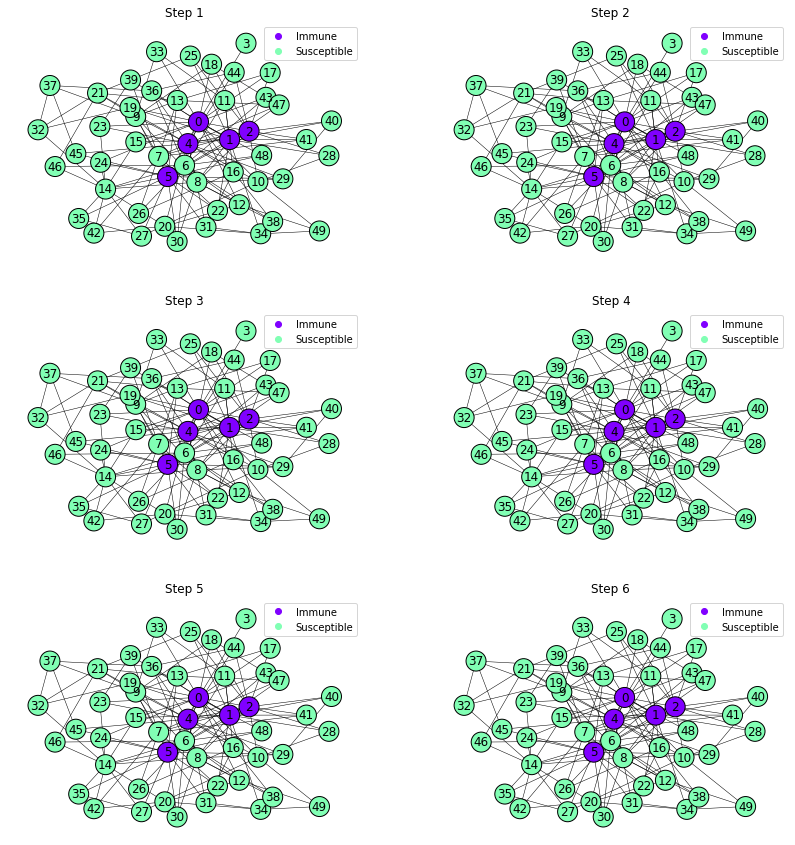

In [50]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for S, I in epidemic[:6]:
    colors = I + 1
    colors[immune] = -1
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Immune', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

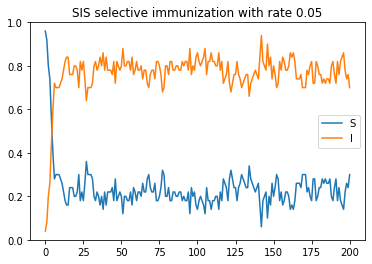

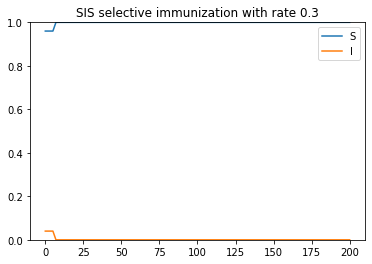

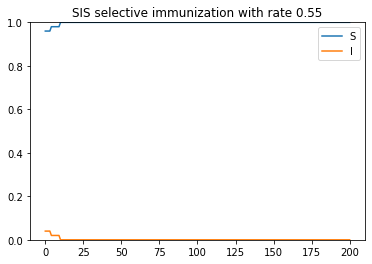

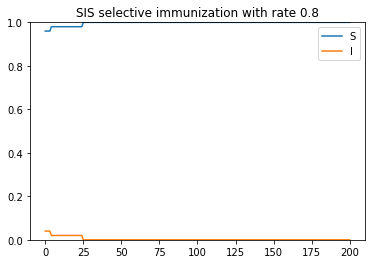

In [51]:
for i in range(1, 20, 5):
    immune, epidemic = selectively_immunized_sis_model(i / 20, G, S, I, beta, gamma, 200)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS selective immunization with rate {i / 20}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)
    plt.show()

We can see that Selective Immunization requires less rate of population to be vaccinized

### Task 9. Degree assortativity and epidemics  (1.5 point)

Most real-world networks are assortative. So high degree nodes tend to connect to other high degree nodes.
Such nodes have a more significant probability of being infected because of the larger number of neighbours. So, when hubs are connected, the virus will spread faster.

Let us see that effect.

In the current task you need to realize `sir_network` that simulates node-level SIR model. Function takes similar input as SIRS except of `delta` probability.

In [54]:
def sir_networks(G, S, I, R, beta, gamma, k):
    return sirs_networks(G, S, I, R, beta, gamma, 0, k)

In [55]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

beta = 0.1
gamma = 0.1
delta = 0.1

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
R = np.zeros(len(G))
epidemic = sir_networks(G, S, I, R, beta, gamma, 100)

assert epidemic.sum() == 5050
assert epidemic.shape == (101, 3, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5050

Also, we need to define generator for networks with different levels of degree assortativities.

The function `generate_network` generates random graph (Erdos Renyi) with `n` nodes and `m-k` edges. If graph is assortative, connect `k` pairs of nodes with highest degree. If graph is disassortative, add `k` edges between high and low degree nodes. Prevent self-loops and parallel edges.

In [69]:
def generate_network(n, m, k, assortative=True):
    G = nx.random_graphs.erdos_renyi_graph(n, 2 * (m-k) / (n * (n-1)))
    nk = m - G.number_of_edges()
    high_degree = [a for a, b in sorted(G.degree(), key=lambda x : x[1], reverse = True)[:k]]
    if assortative:
      for a in high_degree:
        if nk == 0:
          break
        for b in high_degree:
          if a == b or G.has_edge(a, b):
            continue
          if nk == 0:
            break
          G.add_edge(a, b)
          nk-=1
    else:
      low_degree = [a for a, b in sorted(G.degree(), key=lambda x : x[1])[:k]]
      for a in high_degree:
        if nk == 0:
          break
        for b in low_degree:
          if a == b or G.has_edge(a, b):
            continue
          if nk == 0:
            break
          G.add_edge(a, b)
          nk-=1
    return G

In [72]:
G = generate_network(1000, 2000, 50, assortative=True)
assert len(list(nx.selfloop_edges(G))) == 0
assert nx.to_numpy_array(G).max() == 1
assert G.number_of_nodes() == 1000
assert G.number_of_edges() == 2000
assert round(nx.degree_assortativity_coefficient(G), 4) > 0.08

G = generate_network(1000, 2000, 50, assortative=False)
assert round(nx.degree_assortativity_coefficient(G), 4) < -0.08

Let us generate some epidemic trajectories for graphs with different degree assortativity

In [73]:
beta = 0.1
gamma = 0.1
delta = 0.1

In [74]:
disassortative = np.zeros(51)
for i in trange(50):
    G = generate_network(1000, 2000, 50, assortative=False)
    I = np.zeros(len(G))
    I[:3] = 1
    S = 1 - I
    R = np.zeros(len(G))
    epidemic = sir_networks(G, S, I, R, beta, gamma, 50)
    disassortative += epidemic.sum(axis=2)[:, 1] / 50

  0%|          | 0/50 [00:00<?, ?it/s]

In [75]:
neutral = np.zeros(51)
for i in trange(50):
    G = nx.gnm_random_graph(1000, 2000)
    I = np.zeros(len(G))
    I[:3] = 1
    S = 1 - I
    R = np.zeros(len(G))
    epidemic = sir_networks(G, S, I, R, beta, gamma, 50)
    neutral += epidemic.sum(axis=2)[:, 1] / 50

  0%|          | 0/50 [00:00<?, ?it/s]

In [76]:
assortative = np.zeros(51)
for i in trange(50):
    G = generate_network(1000, 2000, 50, assortative=True)
    I = np.zeros(len(G))
    I[:3] = 1
    S = 1 - I
    R = np.zeros(len(G))
    epidemic = sir_networks(G, S, I, R, beta, gamma, 50)
    assortative += epidemic.sum(axis=2)[:, 1] / 50

  0%|          | 0/50 [00:00<?, ?it/s]

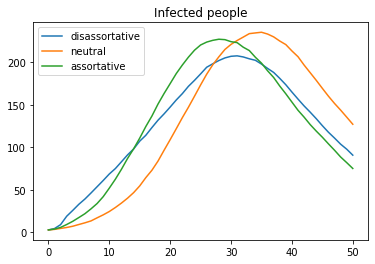

In [77]:
plt.plot(disassortative, label='disassortative')
plt.plot(neutral, label='neutral')
plt.plot(assortative, label='assortative')
plt.legend()
plt.title('Infected people');

Given that hubs are the first to be infected in a network, assortativity accelerates the spread of a pathogen. In contrast disassortativity slows the spreading process.

### Task 10. Self-isolation  (1 points)

In this task we will see how self-isolation helps to beat epidemics.

The general idea is similar to the immunization: we make some nodes invisible for the virus.

Here you need to define the `random_self_isolation` function, that works similarly to the `randomly_immunized_sis_model`, but after some steps all isolated nodes become visible for the virus.

1. Select part (with rate `g`) of nodes randomly
2. Remove all edges adjacent to selected nodes
3. Run `sis_networks` model for number of steps `t` (self-isolation period)
4. Add all removed edges
5. Run `sis_networks` model for number of steps `k - t` keeping previous state

_Hint: use `np.random.choice` to select random subsample_

In [83]:
def self_isolation_sis_model(g, t, G, S, I, beta, gamma, k):
    immun = np.random.choice(G.nodes(), int(g*G.number_of_nodes()))
    tempG = G.copy()
    for i in immun:
        tempG.remove_edges_from([(i, k) for k in G.nodes()])
    epidemic = list(sis_networks(tempG, S, I, beta, gamma, t))
    epidemic.extend(sis_networks(G, epidemic[-1][0], epidemic[-1][1], beta, gamma, k-t))
    return immun, np.array(epidemic)



In [84]:
G = nx.barabasi_albert_graph(50, 3, seed=0)

I = np.zeros(len(G))
I[:3] = 1
S = 1 - I
beta = 0.2
gamma = 0.1
g = 0.3
t = 3

immune, epidemic = self_isolation_sis_model(g, t, G, S, I, beta, gamma, 100)
assert epidemic.sum() == 5100
assert epidemic.shape == (102, 2, 50)
assert (epidemic.sum(axis=1) == 1).sum() == 5100

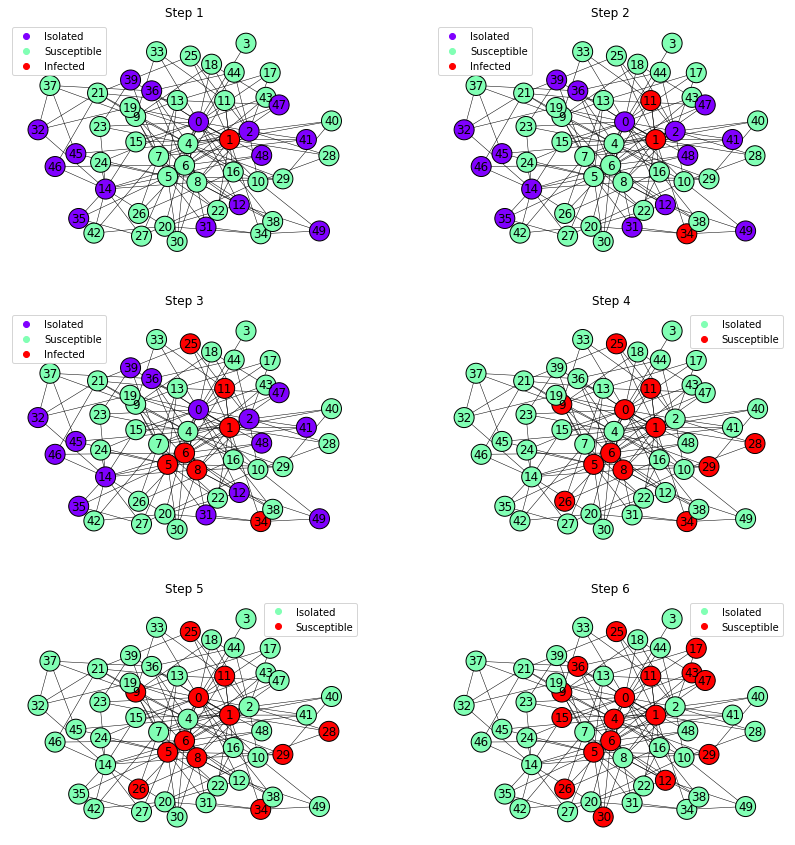

In [85]:
plt.figure(figsize=(7*2, 5*3))
pos = nx.kamada_kawai_layout(G)
i = 1
for step, (S, I) in enumerate(epidemic[:6]):
    colors = I + 1
    if step < 3:
        colors[immune] = -1
    plt.subplot(3, 2, i)
    nodes = nx.draw_networkx_nodes(G, pos, 
            node_size=400,
            node_color=colors, 
            vmin=0, vmax=2, 
            cmap=plt.cm.rainbow,
            edgecolors='black')
    nx.draw_networkx_edges(G, pos,
            width=0.5,
            node_size=400)
    nx.draw_networkx_labels(G, pos)
    plt.title('Step {}'.format(i))
    plt.legend(nodes.legend_elements()[0], ['Isolated', 'Susceptible', 'Infected'])
    plt.axis('off')
    i += 1

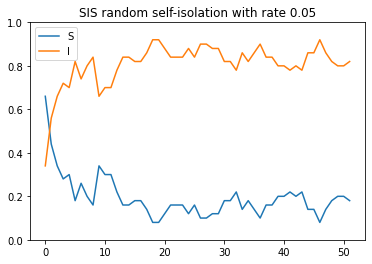

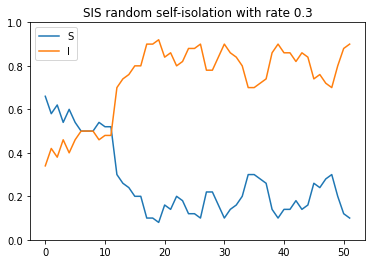

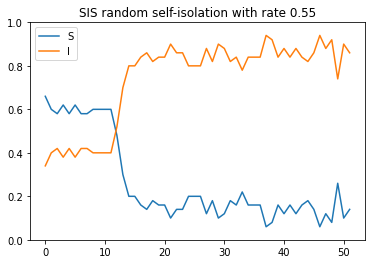

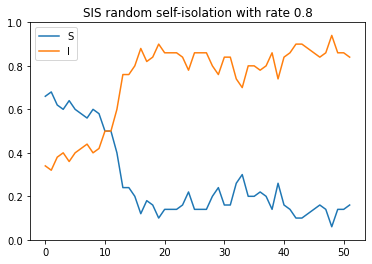

In [86]:
for i in range(1, 20, 5):
    immune, epidemic = self_isolation_sis_model(i / 20, 10, G, S, I, beta, gamma, 50)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS random self-isolation with rate {i / 20}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)
    plt.show()

Here we can see that high self-isolated rate of population just delays a case when all people to be infected

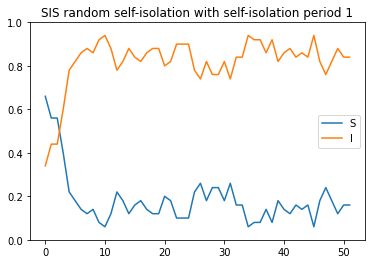

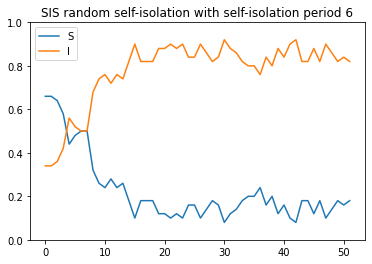

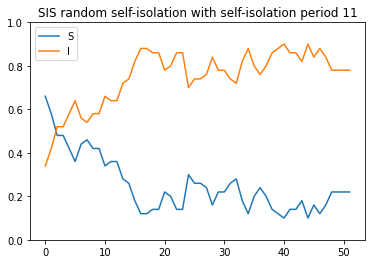

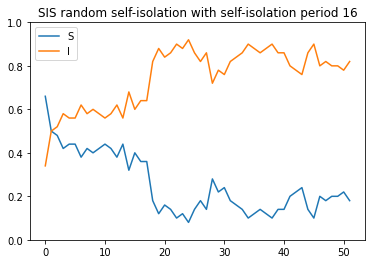

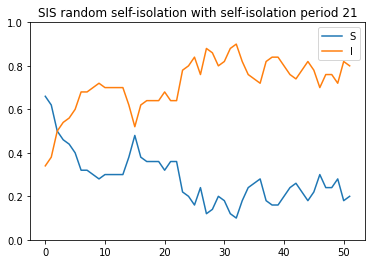

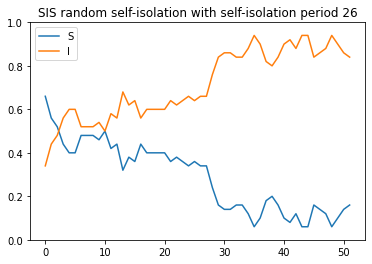

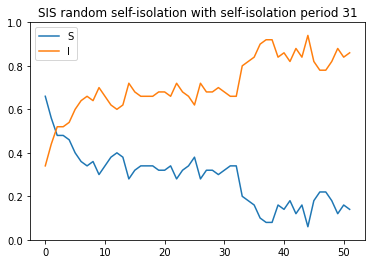

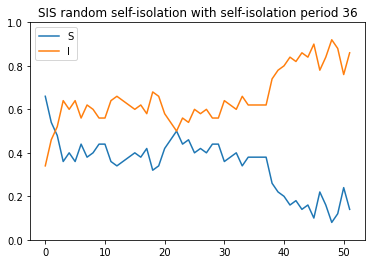

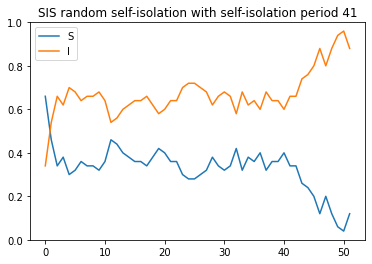

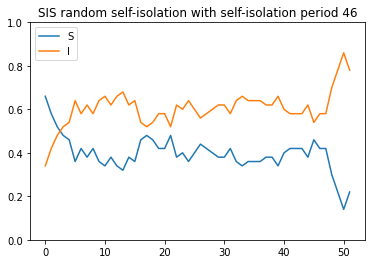

In [87]:
for i in range(1, 50, 5):
    immune, epidemic = self_isolation_sis_model(0.3, i, G, S, I, beta, gamma, 50)
    plt.plot(epidemic.mean(axis=2))
    plt.title(f"SIS random self-isolation with self-isolation period {i}")
    plt.legend(['S', 'I'])
    plt.ylim(0, 1)
    plt.show()

So, this model shows that the only efficient way to beat the pandemic is vaccination.